# Video Conference Attention Detection

**Author:**
- Ayaz Maredia
- Divy Goswami
- Kartik Prajapati
- Krish Patel
- Parth Sathiya


These are the libraries that needs to be install.

In [1]:
# !pip install opencv-python

In [2]:
# !pip install tensorflow

In [3]:
# !pip install deepface

In [4]:
# !pip install mediapipe

In [5]:
# !pip install pandas

In [6]:
# !pip install seaborn

In [1]:
import torch

In [2]:
print(torch.cuda.is_available())

True


#Video analysis

In [34]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from IPython.display import display, clear_output
import torchvision.models as pretrain_models  # For pre-trained models

In [35]:
# Configuration
VIDEO_PATH = "./video1.mp4"  # Change to your video path
OUTPUT_DIR = "output_frames"
RESULTS_CSV = "attention_results.csv"
# # For a 30fps video:
# 1 frame per 30 sec video
FRAME_EXTRACTION_RATE = 1  # Extract every Nth frame (1=all frames)
MODEL_PATHS = {
    "SimpleCNN": "models/CL_customCNNmodel.pth",
    "ResNet18": "models/CL_Resnet18_model.pth",
    "VGG19":"models/CL_vgg19_model.pth"
}

In [36]:
# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [37]:
# model_test = SimpleCNN().to(device)
# model_test.load_state_dict(torch.load("models/final_attention_model.pth"))


In [38]:
# Custom CNN Architecture
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 54 * 54, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (batch, 16, 111, 111)
        x = self.pool(F.relu(self.conv2(x)))  # (batch, 32, 54, 54)
        x = x.view(-1, 32 * 54 * 54)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x



# Load models
def load_model(model_name):
    if model_name == "SimpleCNN":
        model = SimpleCNN() #.to(device)  # Replace with your SimpleCNN class
        # model.load_state_dict(torch.load("models/customCNNmodel.pth"))
    elif model_name == "ResNet18":
        # model = pretrain_models.resnet18(pretrained=False)
        # num_features = model.fc.in_features
        # model.fc = nn.Linear(num_features, 1)
        # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = pretrain_models.resnet18(pretrained=False)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(  # ← Key fix
            nn.Linear(num_features, 1),
            nn.Sigmoid()  # Add this if your saved model had it
        )
    elif model_name == "VGG19":
        # --- Load Pre-trained VGG19 ---
        model = pretrain_models.vgg19(pretrained=True)        
        # Freeze all layers by default (optional: unfreeze later for fine-tuning)
        for param in model.parameters():
            param.requires_grad = False
        
        # Modify the classifier for binary classification
        # Original VGG19 has 1000 output features (for ImageNet)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(num_features, 1),  # Single output neuron
            nn.Sigmoid()  # Sigmoid for binary probability
        )
        # vgg19_model = vgg19_model.to(device)

    model.load_state_dict(torch.load(MODEL_PATHS[model_name]))
    model.eval()
    return model #.to(device)

models_dict = {name: load_model(name) for name in MODEL_PATHS}


C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\spdsp\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
# Frame extraction
def extract_frames(video_path, output_dir, frame_rate=1):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_rate == 0:
            frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            extracted_frames.append({
                "frame_num": frame_count,
                "frame_path": frame_path
            })

        frame_count += 1

    cap.release()
    return extracted_frames

In [40]:
# Prediction function
def predict_attention(frame_path, models):
    img = Image.open(frame_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)#.to(device)

    results = {"frame_path": frame_path}

    with torch.no_grad():
        for model_name, model in models.items():
            output = model(img_tensor)
            prob = torch.sigmoid(output).item()
            pred = "Attentive" if prob > 0.5 else "Not Attentive"
            results[f"{model_name}_prob"] = prob
            results[f"{model_name}_pred"] = pred

    return results

In [41]:
# Main processing function
def process_video(video_path):
    # Step 1: Extract frames
    print("Extracting frames...")
    frames = extract_frames(video_path, OUTPUT_DIR, FRAME_EXTRACTION_RATE)

    # Step 2: Process each frame
    results = []
    total_frames = len(frames)

    for i, frame_info in enumerate(frames):
        # Display progress
        clear_output(wait=True)
        print(f"Processing frame {i+1}/{total_frames}")

        # Make predictions
        frame_result = predict_attention(frame_info["frame_path"], models_dict)
        frame_result["frame_num"] = frame_info["frame_num"]
        results.append(frame_result)

    # Step 3: Create DataFrame
    df = pd.DataFrame(results)

    # Step 4: Calculate attention scores
    for model_name in MODEL_PATHS.keys():
        attentive_count = df[f"{model_name}_pred"].value_counts().get("Attentive", 0)
        df[f"{model_name}_score"] = attentive_count / len(df)

    # Step 5: Save results
    # df.to_csv(RESULTS_CSV, index=False)
    print(f"Analysis complete. Results saved to {RESULTS_CSV}")

    return df

In [42]:
# Run the analysis
results_df = process_video(VIDEO_PATH)

# Display sample results
display(results_df.head())


Processing frame 300/300
Analysis complete. Results saved to attention_results.csv


,frame_path,SimpleCNN_prob,SimpleCNN_pred,ResNet18_prob,ResNet18_pred,VGG19_prob,VGG19_pred,frame_num,SimpleCNN_score,ResNet18_score,VGG19_score
0,output_frames\frame_0000.jpg,0.678121,Attentive,0.635431,Attentive,0.645298,Attentive,0,1.0,1.0,1.0
1,output_frames\frame_0001.jpg,0.680296,Attentive,0.627791,Attentive,0.633323,Attentive,1,1.0,1.0,1.0
2,output_frames\frame_0002.jpg,0.679658,Attentive,0.628392,Attentive,0.632781,Attentive,2,1.0,1.0,1.0
3,output_frames\frame_0003.jpg,0.708541,Attentive,0.610181,Attentive,0.624181,Attentive,3,1.0,1.0,1.0
4,output_frames\frame_0004.jpg,0.708534,Attentive,0.610920,Attentive,0.626016,Attentive,4,1.0,1.0,1.0


In [44]:
# Calculate the average probabilities
simplecnn_avg = results_df['SimpleCNN_prob'].mean()
resnet18_avg = results_df['ResNet18_prob'].mean()

# Update predictions
results_df['SimpleCNN_pred'] = results_df['SimpleCNN_prob'].apply(lambda x: 'Attentive' if x >= simplecnn_avg else 'Not Attentive')
results_df['ResNet18_pred'] = results_df['ResNet18_prob'].apply(lambda x: 'Attentive' if x >= resnet18_avg else 'Not Attentive')
results_df['VGG19_pred'] = results_df['VGG19_prob'].apply(lambda x: 'Attentive' if x >= resnet18_avg else 'Not Attentive')


# Update scores based on predictions
results_df['SimpleCNN_score'] = results_df['SimpleCNN_pred'].apply(lambda x: 1.0 if x == 'Attentive' else 0.0)
results_df['ResNet18_score'] = results_df['ResNet18_pred'].apply(lambda x: 1.0 if x == 'Attentive' else 0.0)
results_df['VGG19_score'] = results_df['VGG19_pred'].apply(lambda x: 1.0 if x == 'Attentive' else 0.0)


# Optional: Save the updated DataFrame
# df.to_csv('updated_predictions.csv', index=False)

# Display the updated predictions
# print(results_df[['SimpleCNN_prob', 'SimpleCNN_pred', 'ResNet18_prob', 'ResNet18_pred']].head())


In [45]:
# results_df.to_csv(RESULTS_CSV, index=False)
results_df

,frame_path,SimpleCNN_prob,SimpleCNN_pred,ResNet18_prob,ResNet18_pred,VGG19_prob,VGG19_pred,frame_num,SimpleCNN_score,ResNet18_score,VGG19_score
0,output_frames\frame_0000.jpg,0.678121,Attentive,0.635431,Attentive,0.645298,Attentive,0,1.0,1.0,1.0
1,output_frames\frame_0001.jpg,0.680296,Attentive,0.627791,Attentive,0.633323,Attentive,1,1.0,1.0,1.0
2,output_frames\frame_0002.jpg,0.679658,Attentive,0.628392,Attentive,0.632781,Attentive,2,1.0,1.0,1.0
3,output_frames\frame_0003.jpg,0.708541,Attentive,0.610181,Not Attentive,0.624181,Attentive,3,1.0,0.0,1.0
4,output_frames\frame_0004.jpg,0.708534,Attentive,0.610920,Attentive,0.626016,Attentive,4,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
295,output_frames\frame_0295.jpg,0.591739,Not Attentive,0.593337,Not Attentive,0.572028,Not Attentive,295,0.0,0.0,0.0
296,output_frames\frame_0296.jpg,0.661833,Attentive,0.581898,Not Attentive,0.532565,Not Attentive,296,1.0,0.0,0.0
297,output_frames\frame_0297.jpg,0.661315,Attentive,0.584073,Not Attentive,0.532499,Not Attentive,297,1.0,0.0,0.0
298,output_frames\frame_0298.jpg,0.675339,Attentive,0.621506,Attentive,0.536539,Not Attentive,298,1.0,1.0,0.0


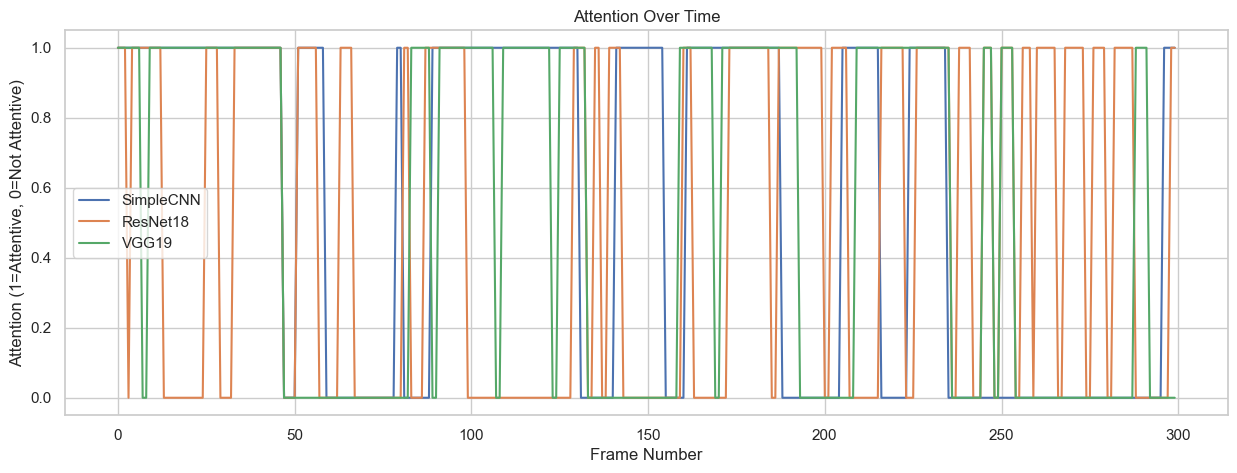

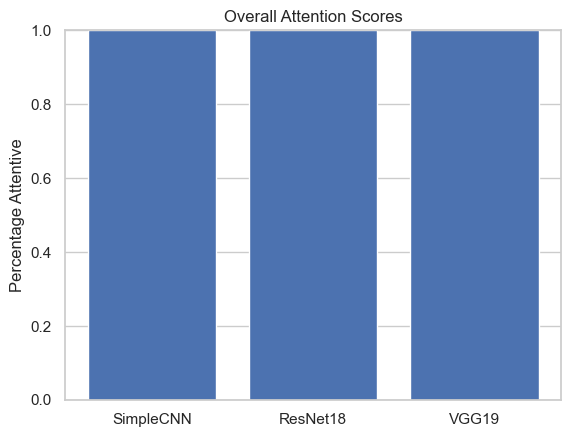

In [46]:


# Visualization
def visualize_results(df, models_dict):
    plt.figure(figsize=(15, 5))

    # Plot attention over time
    for model_name in models_dict.keys():
        df[f"{model_name}_numeric"] = df[f"{model_name}_pred"].apply(lambda x: 1 if x == "Attentive" else 0)
        plt.plot(df["frame_num"], df[f"{model_name}_numeric"], label=model_name)

    plt.title("Attention Over Time")
    plt.xlabel("Frame Number")
    plt.ylabel("Attention (1=Attentive, 0=Not Attentive)")
    plt.legend()
    plt.show()

    # Display attention scores
    scores = {model: df[f"{model}_score"].iloc[0] for model in models_dict.keys()}
    plt.bar(scores.keys(), scores.values())
    plt.title("Overall Attention Scores")
    plt.ylabel("Percentage Attentive")
    plt.ylim(0, 1)
    plt.show()

visualize_results(results_df, models_dict)

In [47]:
results_df.to_csv(RESULTS_CSV, index=False)

In [48]:
results_df

,frame_path,SimpleCNN_prob,SimpleCNN_pred,ResNet18_prob,ResNet18_pred,VGG19_prob,VGG19_pred,frame_num,SimpleCNN_score,ResNet18_score,VGG19_score,SimpleCNN_numeric,ResNet18_numeric,VGG19_numeric
0,output_frames\frame_0000.jpg,0.678121,Attentive,0.635431,Attentive,0.645298,Attentive,0,1.0,1.0,1.0,1,1,1
1,output_frames\frame_0001.jpg,0.680296,Attentive,0.627791,Attentive,0.633323,Attentive,1,1.0,1.0,1.0,1,1,1
2,output_frames\frame_0002.jpg,0.679658,Attentive,0.628392,Attentive,0.632781,Attentive,2,1.0,1.0,1.0,1,1,1
3,output_frames\frame_0003.jpg,0.708541,Attentive,0.610181,Not Attentive,0.624181,Attentive,3,1.0,0.0,1.0,1,0,1
4,output_frames\frame_0004.jpg,0.708534,Attentive,0.610920,Attentive,0.626016,Attentive,4,1.0,1.0,1.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,output_frames\frame_0295.jpg,0.591739,Not Attentive,0.593337,Not Attentive,0.572028,Not Attentive,295,0.0,0.0,0.0,0,0,0
296,output_frames\frame_0296.jpg,0.661833,Attentive,0.581898,Not Attentive,0.532565,Not Attentive,296,1.0,0.0,0.0,1,0,0
297,output_frames\frame_0297.jpg,0.661315,Attentive,0.584073,Not Attentive,0.532499,Not Attentive,297,1.0,0.0,0.0,1,0,0
298,output_frames\frame_0298.jpg,0.675339,Attentive,0.621506,Attentive,0.536539,Not Attentive,298,1.0,1.0,0.0,1,1,0


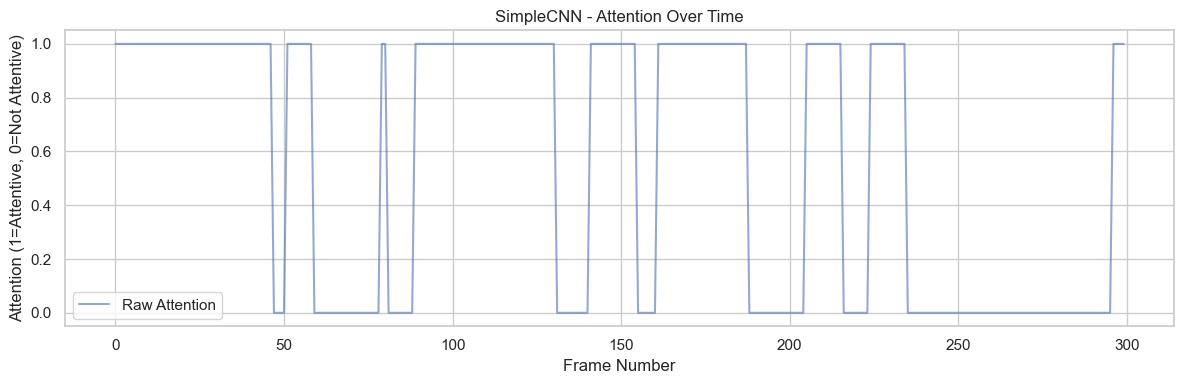

C:\Users\spdsp\AppData\Local\Temp\ipykernel_16716\213350311.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[model_name], y=[score], palette="Blues_d")


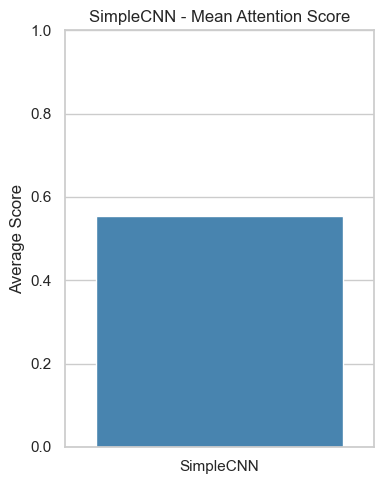

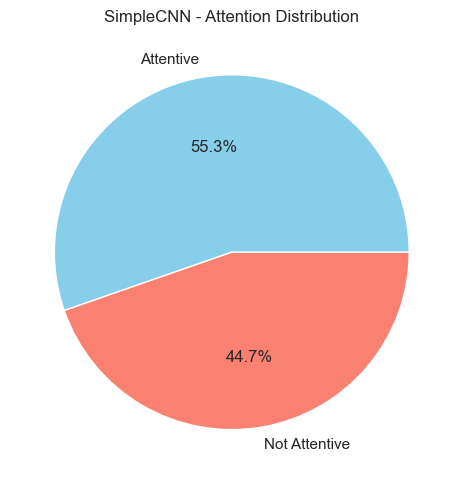

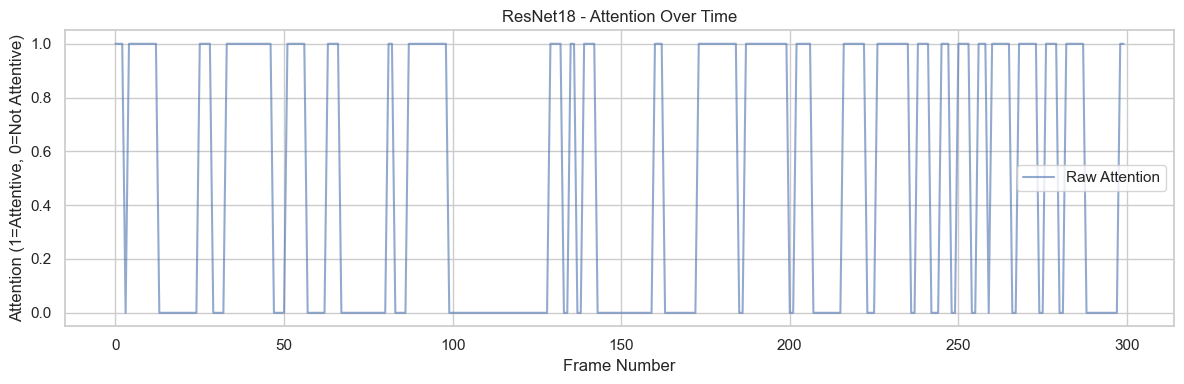

C:\Users\spdsp\AppData\Local\Temp\ipykernel_16716\213350311.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[model_name], y=[score], palette="Blues_d")


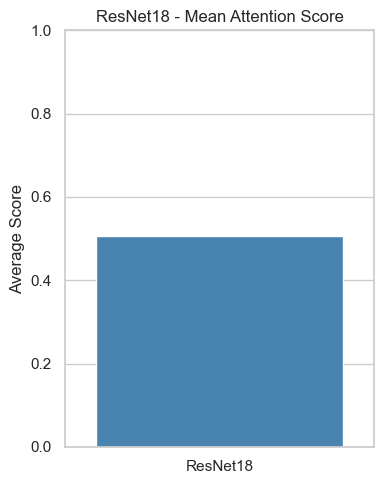

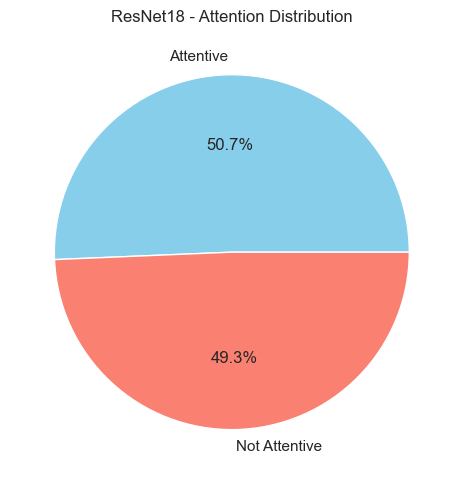

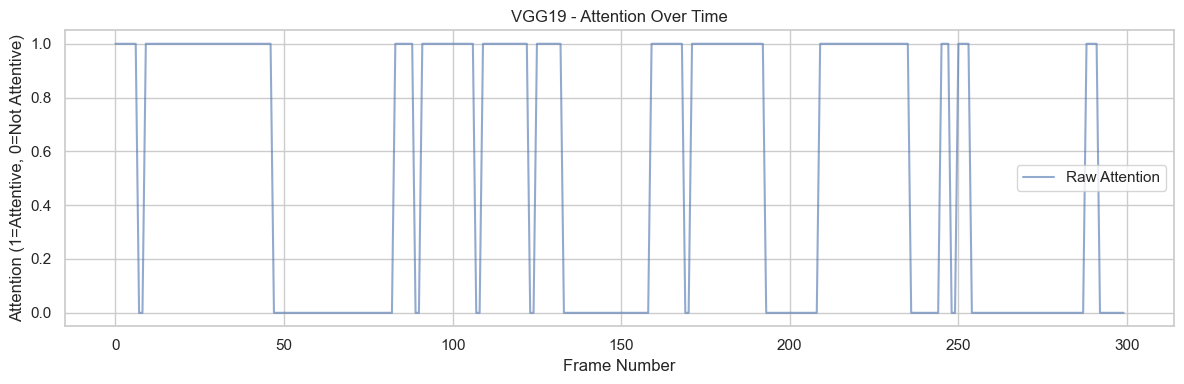

C:\Users\spdsp\AppData\Local\Temp\ipykernel_16716\213350311.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[model_name], y=[score], palette="Blues_d")


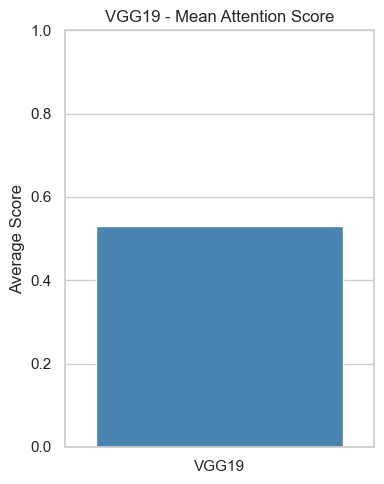

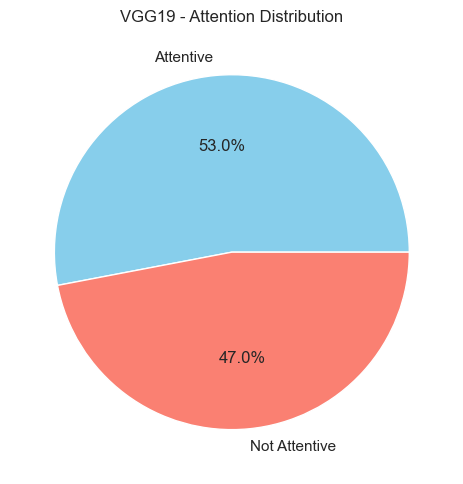

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(df, models_dict):
    sns.set(style="whitegrid")
    
    for model_name in models_dict.keys():
        # Convert predictions to numeric if not already done
        df[f"{model_name}_numeric"] = df[f"{model_name}_pred"].apply(lambda x: 1 if x == "Attentive" else 0)

        # --- Line Plot: Attention Over Time ---
        plt.figure(figsize=(12, 4))
        plt.plot(df["frame_num"], df[f"{model_name}_numeric"], label="Raw Attention", alpha=0.6)
        # plt.plot(df["frame_num"], df[f"{model_name}_numeric"].rolling(window=10).mean(), label="Rolling Average", linewidth=2)
        plt.title(f"{model_name} - Attention Over Time")
        plt.xlabel("Frame Number")
        plt.ylabel("Attention (1=Attentive, 0=Not Attentive)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # --- Bar Chart: Overall Attention Score ---
        score = df[f"{model_name}_score"].mean()
        plt.figure(figsize=(4, 5))
        sns.barplot(x=[model_name], y=[score], palette="Blues_d")
        plt.ylim(0, 1)
        plt.title(f"{model_name} - Mean Attention Score")
        plt.ylabel("Average Score")
        plt.tight_layout()
        plt.show()

        # --- Pie Chart: Attentive vs Not Attentive ---
        counts = df[f"{model_name}_pred"].value_counts()
        plt.figure(figsize=(5, 5))
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=["skyblue", "salmon"])
        plt.title(f"{model_name} - Attention Distribution")
        plt.tight_layout()
        plt.show()

        # --- Optional: Heatmap (if many models or categorical comparison needed)
        # Not included by default, but can add if you compare multiple models frame-wise

visualize_results(results_df, models_dict)

In [ ]:
# import torch
# from PIL import Image
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import torchvision.models as pretrain_models  # For pre-trained models

# # 1. Load the trained model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# resnet18_model_test = pretrain_models.resnet18(pretrained=False)
# num_features = resnet18_model_test.fc.in_features
# resnet18_model_test.fc = nn.Sequential(  # ← Key fix
#     nn.Linear(num_features, 1),
#     nn.Sigmoid()  # Add this if your saved model had it
# )
# resnet18_model_test.load_state_dict(torch.load("models/final_resnet18_model.pth", map_location=device))
# resnet18_model_test = resnet18_model_test.to(device)
# resnet18_model_test.eval()


In [ ]:
# # import torch
# # from PIL import Image
# # import torchvision.transforms as transforms
# # import matplotlib.pyplot as plt

# # # 1. Load the trained model
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # resnet18_model_test = pretrain_models.resnet18(pretrained=False)
# # num_features = resnet18_model_test.fc.in_features
# # resnet18_model_test.fc = nn.Linear(num_features, 1)  # Match your training architecture
# # resnet18_model_test.load_state_dict(torch.load("models/final_resnet18_model.pth", map_location=device))
# # resnet18_model_test = resnet18_model_test.to(device)
# # resnet18_model_test.eval()

# # 2. Define image preprocessing (must match your training preprocessing)
# # transform = transforms.Compose([
# #     transforms.Resize(256),
# #     transforms.CenterCrop(224),
# #     transforms.ToTensor(),
# #     transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
# #     std=[0.229, 0.224, 0.225])
# # ])

# # 3. Prediction function
# def predict_attention(image_path, threshold=0.5):
#     # Load and preprocess image
#     image = Image.open(image_path).convert('RGB')
#     image_tensor = transform(image).unsqueeze(0).to(device)


#     # Predict
#     with torch.no_grad():
#         output = resnet18_model_test(image_tensor)
#         probability = torch.sigmoid(output).item()
#         prediction = "Attention" if probability > threshold else "Not Attention"

#     # Visualize
#     plt.imshow(image)
#     # plt.title(f"Prediction: {prediction}\nConfidence: {probability:.4f}")
#     plt.title(f"Prediction: {prediction}\nConfidence: {probability:.4f}")
#     plt.axis('off')
#     plt.show()

#     return prediction, probability, output

# # # 4. Example usage
# # image_path = "path/to/your/test_image.jpg"  # Replace with your image
# # prediction, confidence = predict_attention(image_path)
# # print(f"Prediction: {prediction} (Confidence: {confidence:.2%})")

# def predict_batch(image_paths):
#     results = []
#     for path in image_paths:
#         try:
#             pred, prob, out = predict_attention(path)
#             results.append((path, pred, prob, out))
#         except Exception as e:
#             print(f"Error processing {path}: {str(e)}")
#     return results

# # Example usage:
# image_list = ["./1.jpg", "./2.jpg", "./3.jpg","./4.jpg","./5.png","./visualized_results/viz_12d672b9a62badbd5ed81db8e8164bfa_1920x1080_30_frame0160.jpg"]
# predictions = predict_batch(image_list)
# for path, pred, prob, out in predictions:
#     print(f"{path}: {pred} ({prob:.2%})")
#     print('output',out)


In [ ]:
# !pip install torchcam

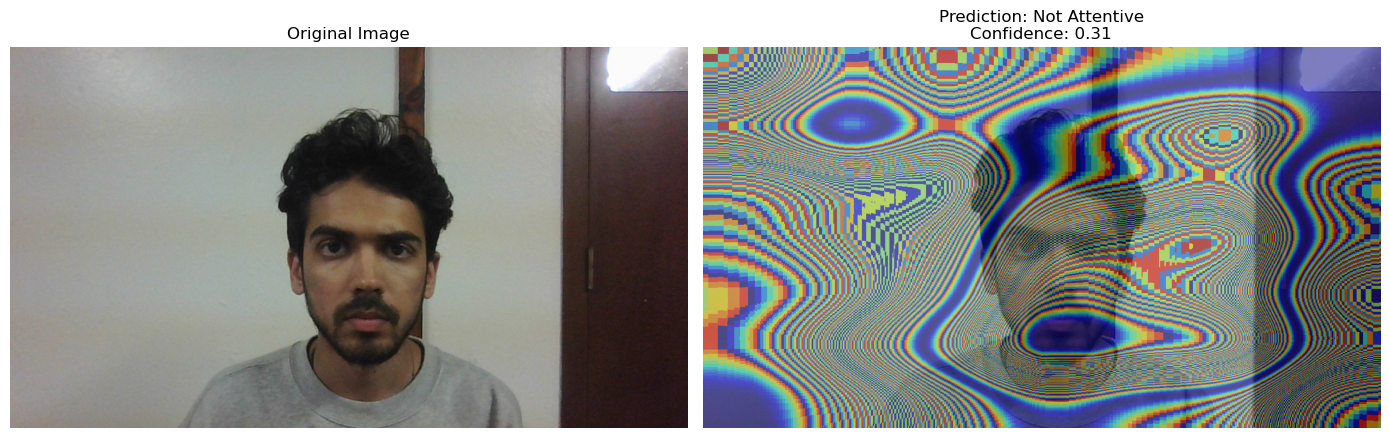

./2.jpg: Not Attentive (30.74%)
Error processing ./1.jpg: cannot register a hook on a tensor that doesn't require gradient


In [69]:
import torch
import torch.nn as nn
from torchvision import models as pretrain_models
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore')

# 1. Setup device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
resnet18_model = pretrain_models.resnet18(pretrained=False)
num_features = resnet18_model.fc.in_features
resnet18_model.fc = nn.Sequential(
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
resnet18_model.load_state_dict(torch.load("models/HL_Resnet18_model.pth", map_location=device))
resnet18_model = resnet18_model.to(device)
resnet18_model.eval()

# 2. Image preprocessing pipeline with grayscale conversion to RGB
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 3. Prediction with CAM visualization
def predict_with_cam(image_path, threshold=0.5):
    try:
        # Load image and ensure RGB format
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        img_tensor = transform(image).unsqueeze(0).to(device)
        img_tensor.requires_grad_(True)
        
        # Initialize CAM extractor
        cam_extractor = SmoothGradCAMpp(resnet18_model)
        
        # Forward pass with gradients
        with torch.enable_grad():
            output = resnet18_model(img_tensor)
            prob = output.item()
            pred = "Attentive" if prob > threshold else "Not Attentive"
            
            # Get activation map
            activation_map = cam_extractor(output.squeeze(0).argmax().item(), output)
        
        # Create overlay
        result = overlay_mask(
            image, 
            to_pil_image(activation_map[0].squeeze(0).detach().cpu()), 
            alpha=0.5
        )
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        ax1.imshow(image)
        ax1.set_title("Original Image")
        ax1.axis('off')
        
        ax2.imshow(result)
        ax2.set_title(f"Prediction: {pred}\nConfidence: {prob:.2f}")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return pred, prob
    
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, None
    finally:
        if 'img_tensor' in locals():
            img_tensor.requires_grad_(False)

# 4. Batch processing function
def process_images(image_paths, threshold=0.5):
    results = []
    for path in image_paths:
        pred, prob = predict_with_cam(path, threshold)
        if pred is not None:
            results.append((path, pred, prob))
            print(f"{path}: {pred} ({prob:.2%})")
    return results

# Example usage
if __name__ == "__main__":
    image_list = [
        "./2.jpg",
        "./1.jpg",
        # Add more images as needed
    ]
    
    results = process_images(image_list)